In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import yfinance as yf
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
import os
# Set both HTTP and HTTPS proxies
os.environ["HTTP_PROXY"]  = "http://proxy.isoad.isogmbh.de:81"
os.environ["HTTPS_PROXY"] = "http://proxy.isoad.isogmbh.de:81"

tickers = ['AAPL', 'SPY']
# Wir laden Close und Volume
df_raw_multi = yf.download(tickers, start="2020-01-01", end="2024-01-01")

# Log-Returns für die Preise berechnen
df_close_log = np.log(df_raw_multi['Close'] / df_raw_multi['Close'].shift(1))

# Volumen normalisieren (Log-Volumen, da die Werte sonst zu groß sind)
df_vol_log = np.log(df_raw_multi['Volume'])

# Zusammenführen in das lange Format
# Wir brauchen eine Spalte 'y' (Zielwert) und 'volume' (exogene Variable)
df_list = []
for ticker in tickers:
    temp_df = pd.DataFrame({
        'ds': df_close_log.index,
        'unique_id': ticker,
        'y': df_close_log[ticker],
        'volume': df_vol_log[ticker]
    }).dropna()
    df_list.append(temp_df)

df_multi = pd.concat(df_list).reset_index(drop=True)

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-18 13:09:10,209	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-02-18 13:09:10,353	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
[*********************100%***********************]  2 of 2 completed


In [64]:
# 1. Daten vorbereiten
# Wir nehmen die Log-Returns von AAPL und SPY sowie das (skalierte) Volumen
df_close_log = np.log(df_raw_multi['Close'] / df_raw_multi['Close'].shift(1))
# Volumen skalieren wir auch (z.B. Log-Differenz oder einfach Log), damit die Skala passt
df_vol_log = np.log(df_raw_multi['Volume']).diff().dropna()

df_list = []

for ticker in ['AAPL', 'SPY']:
    # Preis-Reihe
    df_list.append(pd.DataFrame({
        'ds': df_close_log.index,
        'unique_id': f'{ticker}_price',
        'y': df_close_log[ticker]
    }))
    # Volumen-Reihe (als eigenständiger Kanal)
    df_list.append(pd.DataFrame({
        'ds': df_vol_log.index,
        'unique_id': f'{ticker}_vol',
        'y': df_vol_log[ticker]
    }))

df_multi_final = pd.concat(df_list).dropna().reset_index(drop=True)
df_multi_final['ds'] = pd.to_datetime(df_multi_final['ds'])
# Neue Zielvariable berechnen: Abweichung vom Trend
# Das zwingt das Modell, Momentum zu lernen statt Lags
df_multi_final['y_rolling'] = df_multi_final.groupby('unique_id')['y'].transform(lambda x: x - x.rolling(5).mean())
df_multi_final = df_multi_final.dropna()

# WICHTIG: Überschreibe die ursprüngliche Zielvariable
# Wir behalten 'y' für später (zum Backtesten), aber das Modell lernt auf 'y_rolling'
df_train_momentum = df_multi_final.copy()
df_train_momentum['y'] = df_train_momentum['y_rolling']

In [67]:
from pytorch_lightning.loggers import CSVLogger

# 1. Wir definieren einen Logger, der definitiv eine CSV schreibt
my_logger = CSVLogger("logs", name="patchtst_model")

# 1. Split der multivariaten Daten
train_df = df_multi_final[df_multi_final['ds'] < '2023-01-01']
test_df = df_multi_final[df_multi_final['ds'] >= '2023-01-01']

print(f"Training endet am: {train_df['ds'].max()}")
print(f"Blind-Test startet am: {test_df['ds'].min()}")

from neuralforecast.losses.pytorch import MAE

import torch 
# Logger wie gehabt
my_logger = CSVLogger("logs", name="patchtst_model")

# 2. Modell-Konfiguration
# 2. Modell mit StepLR (stabil und ohne Monitor-Pflicht)
model_stable = PatchTST(
    h=7,
    input_size=10,
    patch_len=2,
    stride=1,
    max_steps=300,           # Deutlich reduzieren!
    learning_rate=5e-5,
    
    # Early Stopping einbauen
    early_stop_patience_steps=3, # Stoppt, wenn val_loss 3x hintereinander steigt
    val_check_steps=50,
    
    # Dropout erhöht die Robustheit (Modell "vergisst" absichtlich Details)
    #dropout=0.3, 
    #fc_dropout=0.3,
    
    optimizer_kwargs={'weight_decay': 0.01} , #Wir bestrafen das Modell für zu komplexe interne Gewichte. Das zwingt es dazu, einfachere (und damit oft stabilere) Lösungen zu finden.
    accelerator='gpu',
    devices=1,
    logger=my_logger
)

# 3. NeuralForecast initialisieren
nf_refined = NeuralForecast(models=[model_refined], freq='B')

# 4. Fit ausführen
# Wenn val_size > 0 ist, erkennt Lightning meist automatisch den 'valid_loss'
nf_refined.fit(df=train_df, val_size=50)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 405 K  | train | 0    
-------------------------------------------------------------------
405 K     Trainable params
3         Non-trainable params
405 K     Total params
1.622     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval

Training endet am: 2022-12-30 00:00:00
Blind-Test startet am: 2023-01-03 00:00:00
                                                                            

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s, v_num=8, train_loss_step=0.103, train_loss_epoch=0.103, valid_loss=0.139]  

`Trainer.fit` stopped: `max_steps=1500` reached.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s, v_num=8, train_loss_step=0.103, train_loss_epoch=0.103, valid_loss=0.139]


logs/patchtst_model/version_8/metrics.csv


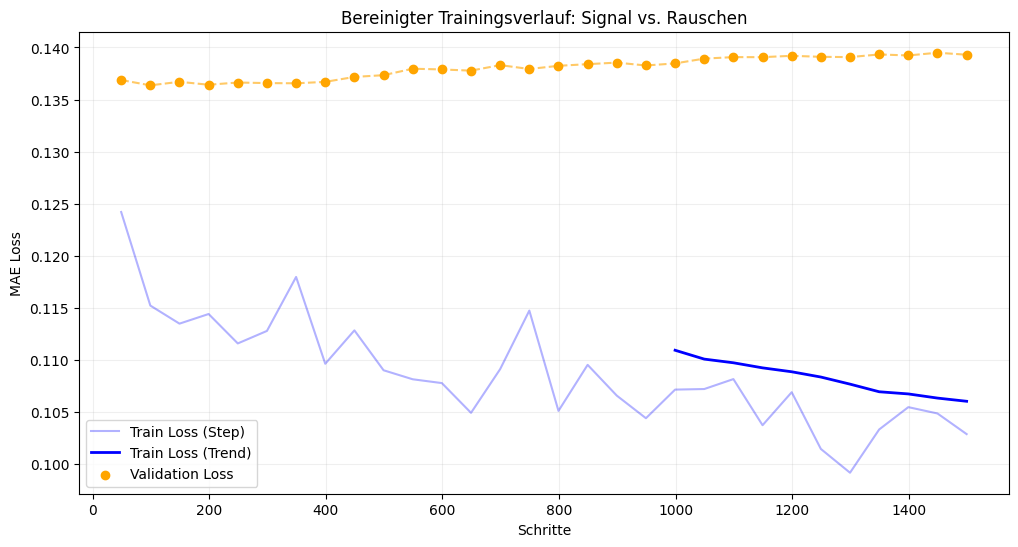

In [70]:
import pandas as pd
import glob
import os

# Nach dem nf.fit(df=train_df, val_size=20) suchen wir die neueste Log-Datei
log_dir = 'logs/patchtst_model/'
latest_log = max(glob.glob(os.path.join(log_dir, 'version_*')), key=os.path.getmtime)
metrics_path = os.path.join(latest_log, 'metrics.csv')

if os.path.exists(metrics_path):
    print(metrics_path)
    # Separate DataFrames für Train und Validation ohne NaNs
    train_metrics = metrics[['step', 'train_loss_step']].dropna()
    val_metrics = metrics[['step', 'valid_loss']].dropna()

    plt.figure(figsize=(12, 6))

    # Train Loss (leicht transparent, da verrauscht)
    plt.plot(train_metrics['step'], train_metrics['train_loss_step'], 
            label='Train Loss (Step)', alpha=0.3, color='blue')

    # Rolling Mean zur Visualisierung des Trends
    plt.plot(train_metrics['step'], train_metrics['train_loss_step'].rolling(window=20).mean(), 
            label='Train Loss (Trend)', color='blue', linewidth=2)

    # Validation Loss (deutlich als Punkte)
    plt.scatter(val_metrics['step'], val_metrics['valid_loss'], 
                label='Validation Loss', color='orange', zorder=5)
    plt.plot(val_metrics['step'], val_metrics['valid_loss'], 
            color='orange', linestyle='--', alpha=0.6)

    plt.title('Bereinigter Trainingsverlauf: Signal vs. Rauschen')
    plt.xlabel('Schritte')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
else:
    print("CSV-Metriken nicht gefunden. Stelle sicher, dass 'val_size' beim fit() angegeben wurde.")

In [71]:
# Cross-Validation auf dem noch nie gesehenen Test-Set
cv_multi = nf_refined.cross_validation(df=test_df, n_windows=100, step_size=1)

# Nur AAPL_price extrahieren und Zick-Zack-Fix anwenden
cv_aapl = cv_multi[cv_multi['unique_id'] == 'AAPL_price'].copy()
cv_aapl_clean = cv_aapl.groupby('cutoff').first().reset_index()

# Trading-Logik: Long-Short
cv_aapl_clean['signal'] = np.where(cv_aapl_clean['PatchTST'] > 0, 1, -1)
cv_aapl_clean['strat_ret'] = cv_aapl_clean['signal'] * cv_aapl_clean['y']

# Kumulative Performance
cv_aapl_clean['cum_strat'] = cv_aapl_clean['strat_ret'].cumsum().apply(np.exp)
cv_aapl_clean['cum_market'] = cv_aapl_clean['y'].cumsum().apply(np.exp)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 405 K  | train | 0    
-------------------------------------------------------------------
405 K     Trainable params
3         Non-trainable params
405 K     Total params
1.622     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0       

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 25.67it/s, v_num=8, train_loss_step=0.0426, train_loss_epoch=0.0426]

`Trainer.fit` stopped: `max_steps=1500` reached.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s, v_num=8, train_loss_step=0.0426, train_loss_epoch=0.0426]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.04it/s]


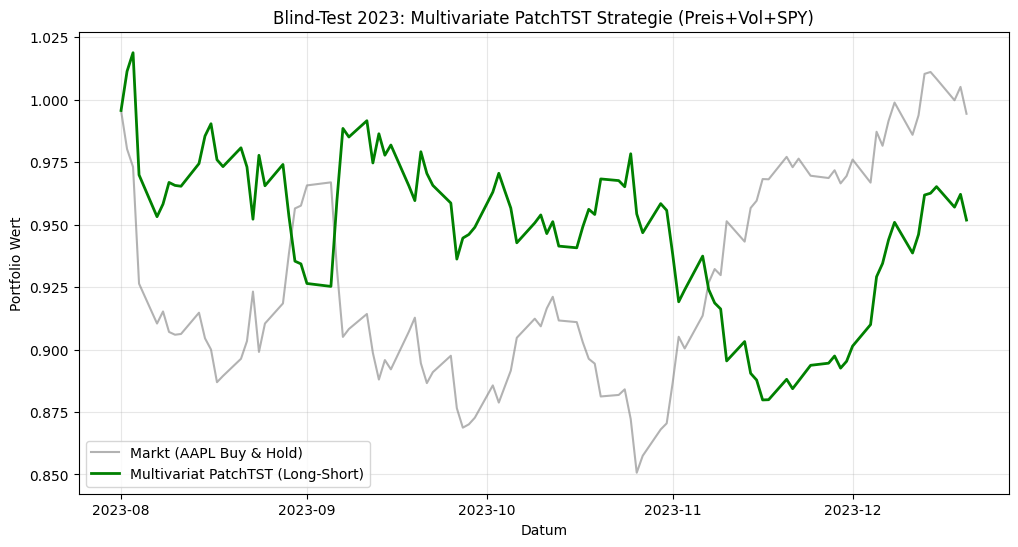

Finale Outperformance (Blind-Test): -4.26 Prozentpunkte


In [72]:
plt.figure(figsize=(12, 6))
plt.plot(cv_aapl_clean['ds'], cv_aapl_clean['cum_market'], label='Markt (AAPL Buy & Hold)', color='gray', alpha=0.6)
plt.plot(cv_aapl_clean['ds'], cv_aapl_clean['cum_strat'], label='Multivariat PatchTST (Long-Short)', color='green', linewidth=2)

plt.title('Blind-Test 2023: Multivariate PatchTST Strategie (Preis+Vol+SPY)')
plt.xlabel('Datum')
plt.ylabel('Portfolio Wert')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Finale Outperformance (Blind-Test): {(cv_aapl_clean['cum_strat'].iloc[-1] - cv_aapl_clean['cum_market'].iloc[-1])*100:.2f} Prozentpunkte")

In [75]:
# 1. Vorhersage generieren (liefert y_rolling Werte)
df_predict = nf_refined.predict()

# 2. Den letzten bekannten Rolling Mean aus den Originaldaten holen
# Wir brauchen den Schnitt der letzten 5 Tage (unser Trend-Anker)
df_trend = df_multi_final.groupby('unique_id')['y'].rolling(5).mean().reset_index()
last_trends = df_trend.groupby('unique_id').tail(1).rename(columns={'y': 'current_trend'})

# 3. Vorhersage mit dem Trend verschmelzen
df_final_forecast = df_predict.merge(last_trends[['unique_id', 'current_trend']], on='unique_id')

# 4. Rückrechnung auf die Log-Return Ebene
# Die Spalte 'PatchTST' enthält jetzt den Vorhersage-Wert für y_rolling
df_final_forecast['y_hat_log_return'] = df_final_forecast['current_trend'] + df_final_forecast['PatchTST']

# Optional: In echte Prozent-Änderung umrechnen
df_final_forecast['y_hat_pct'] = (np.exp(df_final_forecast['y_hat_log_return']) - 1) * 100

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.62it/s]


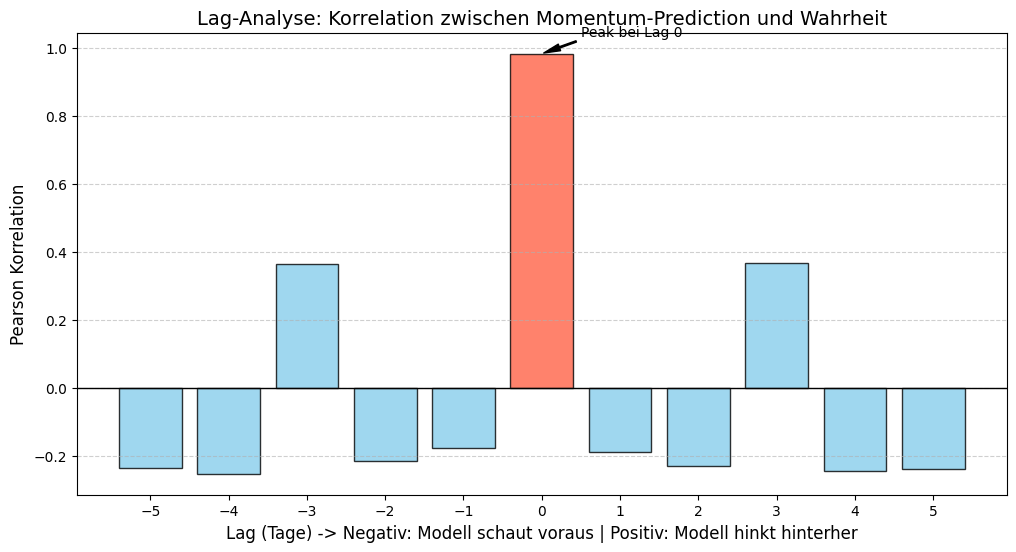

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_lag_correlation(df_results, target_col='y', pred_col='y_hat_log_return', max_lag=5):
    """
    Erstellt eine Lag-Analyse zwischen Vorhersage und echten Werten.
    """
    # Sicherstellen, dass keine NaNs die Korrelation stören
    df_clean = df_results[[target_col, pred_col]].dropna()
    
    lags = range(-max_lag, max_lag + 1)
    correlations = []

    for lag in lags:
        if lag < 0:
            # Korrelation von Vorhersage heute mit Wahrheit in der Zukunft
            corr = df_clean[pred_col].corr(df_clean[target_col].shift(abs(lag)))
        elif lag > 0:
            # Korrelation von Vorhersage heute mit Wahrheit in der Vergangenheit (Der "Lag-Fehler")
            corr = df_clean[pred_col].corr(df_clean[target_col].shift(-lag))
        else:
            # Direkte Korrelation (Lag 0)
            corr = df_clean[pred_col].corr(df_clean[target_col])
        correlations.append(corr)

    # Plotting
    plt.figure(figsize=(12, 6))
    colors = ['#87CEEB' if abs(l) != 0 else '#FF6347' for l in lags]
    bars = plt.bar(lags, correlations, color=colors, alpha=0.8, edgecolor='black')
    
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Lag-Analyse: Korrelation zwischen Momentum-Prediction und Wahrheit', fontsize=14)
    plt.xlabel('Lag (Tage) -> Negativ: Modell schaut voraus | Positiv: Modell hinkt hinterher', fontsize=12)
    plt.ylabel('Pearson Korrelation', fontsize=12)
    plt.xticks(lags)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Höchsten Lag markieren
    max_corr_idx = np.argmax(np.abs(correlations))
    plt.annotate(f'Peak bei Lag {lags[max_corr_idx]}', 
                 xy=(lags[max_corr_idx], correlations[max_corr_idx]),
                 xytext=(lags[max_corr_idx]+0.5, correlations[max_corr_idx]+0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

    plt.show()

# Anwendung (beispielhaft mit deinem df_final_forecast)
# Falls du gegen die echten Log-Returns testen willst:
plot_lag_correlation(df_final_forecast, target_col='y_hat_log_return', pred_col='PatchTST')

In [ ]:
def run_long_term_backtest_fixed(nf_model, df_context, ticker='AAPL_price', windows=100):
    # 1. Cross Validation mit vielen kleinen Fenstern
    # h bleibt bei 7 (wie im Training), n_windows bestimmt die Länge des Backtests
    cv_df = nf_model.cross_validation(
        df=df_context,
        h=7,              # Muss exakt dem h des Modells entsprechen
        step_size=1,      # Jedes Fenster rückt einen Tag vor
        n_windows=windows # Wie viele Tage wir zurückgehen (z.B. 100)
    )
    
    # 2. Wir nehmen aus jedem Fenster nur die Vorhersage für den NÄCHSTEN Tag (cutoff + 1)
    # Das verhindert, dass wir Daten doppelt zählen
    cv_df = cv_df.groupby(['unique_id', 'cutoff']).head(1).copy()
    
    # 3. Filter auf deinen Ticker
    results = cv_df[cv_df['unique_id'] == ticker].copy()
    
    # 4. Rolling Mean aus den Originaldaten für die Rückrechnung
    # Wichtig: Der rolling_mean muss auf dem ursprünglichen 'y' basieren
    df_context = df_context.copy()
    df_context['rolling_mean'] = df_context.groupby('unique_id')['y'].transform(lambda x: x.rolling(5).mean())
    
    # Merge Vorhersage + Rolling Mean
    results = results.merge(
        df_context[['ds', 'unique_id', 'rolling_mean']], 
        on=['ds', 'unique_id'], 
        how='left'
    )
    
    # 5. Rückrechnung: PatchTST (y_rolling) + rolling_mean = y_hat_log
    results['y_hat_log'] = results['rolling_mean'] + results['PatchTST']
    
    # 6. Strategie-Rendite (Signal von heute für Kurs von morgen)
    results['signal'] = np.where(results['y_hat_log'] > 0, 1, -1)
    results['strat_ret'] = results['signal'].shift(1) * results['y']
    
    results = results.dropna(subset=['strat_ret'])
    
    # 7. Performance-Kurven
    results['cum_market'] = np.exp(results['y'].cumsum())
    results['cum_strategy'] = np.exp(results['strat_ret'].cumsum())
    
    return results

# Backtest über 100 Fenster (Tage)
long_results = run_long_term_backtest_fixed(nf_refined, df_multi_final, windows=100)

if long_results is not None and len(long_results) > 0:
    print_stats(long_results)
    # Plot wie gehabt...
else:
    print("Der DataFrame ist immer noch leer. Prüfe: print(cv_df.head())")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 405 K  | train | 0    
-------------------------------------------------------------------
405 K     Trainable params
3         Non-trainable params
405 K     Total params
1.622     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0         Total Flops


/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s, v_num=8, train_loss_step=0.0921, train_loss_epoch=0.0921]

`Trainer.fit` stopped: `max_steps=1500` reached.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s, v_num=8, train_loss_step=0.0921, train_loss_epoch=0.0921]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.40it/s]


KeyError: 'cum_strat'

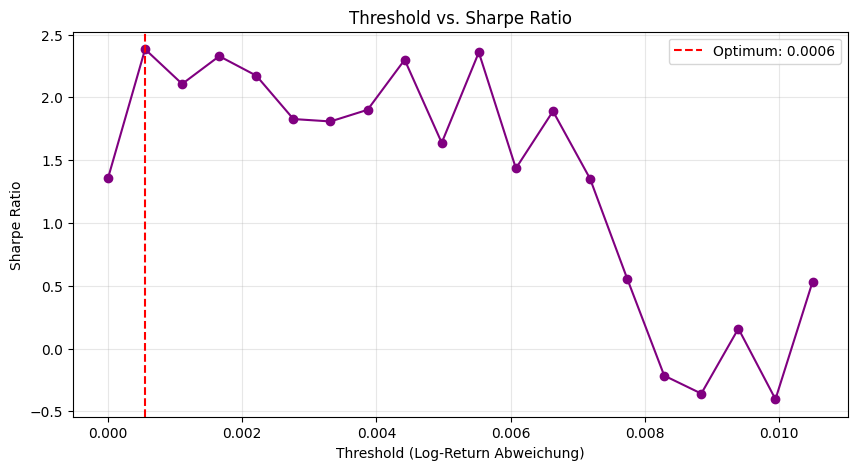

Bester Threshold: 0.000553
Maximale Sharpe Ratio: 2.38
0.0005525255817817248


In [96]:
def optimize_threshold(results_df):
    thresholds = np.linspace(0, results_df['y_hat_log'].std() * 1.5, 20)
    best_sharpe = -np.inf
    best_threshold = 0
    results_list = []

    for t in thresholds:
        # Signal berechnen
        sig = np.where(results_df['y_hat_log'] > t, 1, 
              np.where(results_df['y_hat_log'] < -t, -1, 0))
        
        # Rendite (shifted)
        strat_ret = pd.Series(sig).shift(1).values * results_df['y'].values
        strat_ret = strat_ret[~np.isnan(strat_ret)]
        
        # Sharpe berechnen
        if len(strat_ret) > 0 and strat_ret.std() > 0:
            sharpe = (strat_ret.mean() / strat_ret.std()) * np.sqrt(252)
        else:
            sharpe = 0
            
        results_list.append((t, sharpe))
        
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = t

    # Visualisierung der Optimierung
    plt.figure(figsize=(10, 5))
    ts, ss = zip(*results_list)
    plt.plot(ts, ss, marker='o', color='purple')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimum: {best_threshold:.4f}')
    plt.title('Threshold vs. Sharpe Ratio')
    plt.xlabel('Threshold (Log-Return Abweichung)')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Bester Threshold: {best_threshold:.6f}")
    print(f"Maximale Sharpe Ratio: {best_sharpe:.2f}")
    return best_threshold

# Finde den optimalen Wert
opt_t = optimize_threshold(long_results)
print(opt_t)

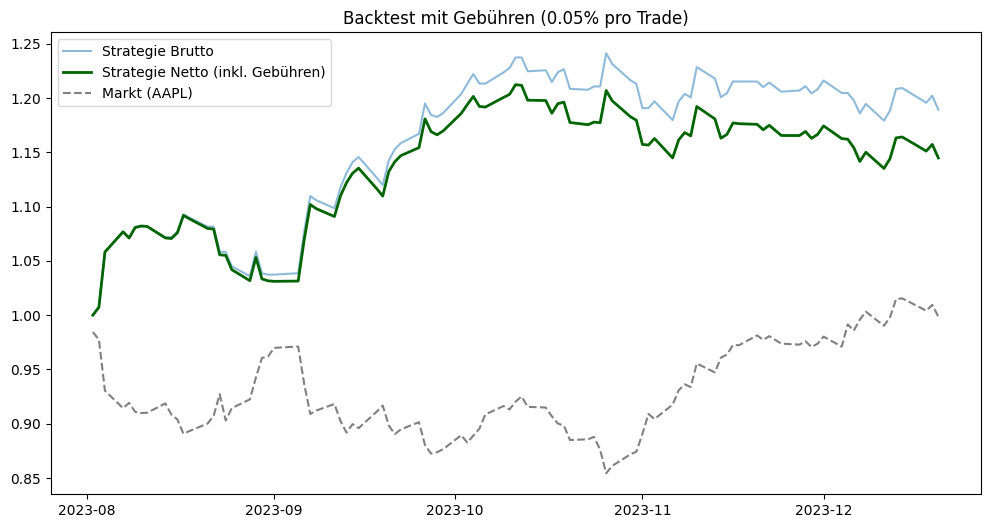

In [97]:
def run_backtest_with_fees(results_df, threshold, fee_per_trade=0.0005):
    """
    Simulation mit Gebühren (0.0005 = 0.05% pro Kauf/Verkauf)
    """
    df = results_df.copy()
    
    # Signal mit optimalem Threshold
    df['signal'] = 0
    df.loc[df['y_hat_log'] > threshold, 'signal'] = 1
    df.loc[df['y_hat_log'] < -threshold, 'signal'] = -1
    
    # Trades identifizieren (Wechsel des Signals)
    # Ein Trade findet statt, wenn sich das Signal im Vergleich zum Vortag ändert
    df['trade_action'] = df['signal'].diff().abs()
    
    # Brutto-Rendite
    df['strat_ret_brutto'] = df['signal'].shift(1) * df['y']
    
    # Netto-Rendite (Brutto - (Anzahl Trades * Gebühr))
    df['strat_ret_netto'] = df['strat_ret_brutto'] - (df['trade_action'] * fee_per_trade)
    
    # Kumulierte Werte
    df['cum_strat_brutto'] = np.exp(df['strat_ret_brutto'].fillna(0).cumsum())
    df['cum_strat_netto'] = np.exp(df['strat_ret_netto'].fillna(0).cumsum())
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['cum_strat_brutto'], label='Strategie Brutto', alpha=0.5)
    plt.plot(df['ds'], df['cum_strat_netto'], label='Strategie Netto (inkl. Gebühren)', color='darkgreen', linewidth=2)
    plt.plot(df['ds'], np.exp(df['y'].cumsum()), label='Markt (AAPL)', color='gray', linestyle='--')
    plt.title(f'Backtest mit Gebühren ({fee_per_trade*100:.2f}% pro Trade)')
    plt.legend()
    plt.show()
    
    return df

# Simulation mit 0.05% Gebühren (typisch für viele Online-Broker/Krypto)
df_netto = run_backtest_with_fees(long_results, threshold=0.000553, fee_per_trade=0.0005)

In [95]:
#Wir führen eine Confidence-Schwelle ein.
# Wenn das Modell nur eine minimale Bewegung vorhersagt, bleiben wir an der Seitenlinie (Signal 0). Wir handeln nur bei "starken" Vorhersagen.    
# Berechne die Standardabweichung der Vorhersagen, um eine Schwelle zu finden
threshold = long_results['y_hat_log'].std() * 0.5

# Neues Signal-Design:
# 1  bei starkem Aufwärtstrend
# -1 bei starkem Abwärtstrend
# 0  bei Unsicherheit (Rauschen)
long_results['signal_filtered'] = 0
long_results.loc[long_results['y_hat_log'] > threshold, 'signal_filtered'] = 1
long_results.loc[long_results['y_hat_log'] < -threshold, 'signal_filtered'] = -1

# Neue Performance berechnen
long_results['strat_ret_filtered'] = long_results['signal_filtered'].shift(1) * long_results['y']
long_results['cum_strat_filtered'] = np.exp(long_results['strat_ret_filtered'].cumsum())

def print_stats_filtered(results):
    # Annualisierte Sharpe Ratio (ausgehend von 252 Handelstagen)
    std = results['strat_ret_filtered'].std()
    mean = results['strat_ret_filtered'].mean()
    sharpe = (mean / std) * np.sqrt(252) if std != 0 else 0
    
    # Maximaler Drawdown
    cum_ret = results['cum_strat_filtered']
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    print(f"--- Strategie-Check cum_strat_filtered ---")
    print(f"Sharpe Ratio:      {sharpe:.2f}")
    print(f"Max Drawdown:      {max_dd:.2f}%")
    print(f"Win Rate (Tage):   {(results['strat_ret'] > 0).mean()*100:.1f}%")
    
def print_stats(results):
    # Annualisierte Sharpe Ratio (ausgehend von 252 Handelstagen)
    std = results['strat_ret'].std()
    mean = results['strat_ret'].mean()
    sharpe = (mean / std) * np.sqrt(252) if std != 0 else 0
    
    # Maximaler Drawdown
    cum_ret = results['cum_strategy']
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    print(f"--- Strategie-Check unfiltered ---")
    print(f"Sharpe Ratio:      {sharpe:.2f}")
    print(f"Max Drawdown:      {max_dd:.2f}%")
    print(f"Win Rate (Tage):   {(results['strat_ret'] > 0).mean()*100:.1f}%")

print_stats(long_results)
print_stats_filtered(long_results)

--- Strategie-Check unfiltered ---
Sharpe Ratio:      1.14
Max Drawdown:      -10.63%
Win Rate (Tage):   52.5%
--- Strategie-Check cum_strat_filtered ---
Sharpe Ratio:      1.80
Max Drawdown:      -4.95%
Win Rate (Tage):   52.5%


In [98]:
# Das Modell lokal speichern
nf_refined.save(path='./checkpoints/patchtst_momentum_model/')

print("Modell erfolgreich gespeichert. Du kannst es nun jederzeit laden.")

Modell erfolgreich gespeichert. Du kannst es nun jederzeit laden.
